# Distribution fitting to data

SciPy has over 80 distributions that may be used to either generate data or test for fitting of exisitng data. In this example we will test for fit against ten distributions and plot the best three fits. For a full list of distributions see:

https://docs.scipy.org/doc/scipy/reference/stats.html

In this example we'll take the first feature (column) from the Wisconsin Breast Cancer data set. 

As usual we will start by loading general modules used, and load our data (selecting the first column for our 'y', the data to be fitted).

In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
# Load data and select first column

from sklearn import datasets
data_set = datasets.load_breast_cancer()
y=data_set.data[:,0]

# Create an index array (x) for data

x = np.arange(len(y))
size = len(y)

## Visualise the data, and show descriptive summary

Before we do any fitting of distributions, it's always good to do a simple visualisation of the data, and show desriptive statistics. We may, for example, decide to perform some outlier removal if we think that necessary (if there appear to be data points that don't belong to the rest of the population).

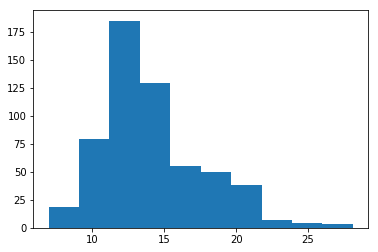

In [2]:
plt.hist(y)
plt.show()

If we put the data in a Pandas Dataframe we can use the Pandas secribe method to show a summary.

In [3]:
y_df = pd.DataFrame(y, columns=['Data'])
y_df.describe()

,Data
count,569.000000
mean,14.127292
std,3.524049
min,6.981000
25%,11.700000
50%,13.370000
75%,15.780000
max,28.110000


## Fitting a range of distribution and test for goodness of fit

This method will compare will fit a number of distributions to our data, compare goodness of fit with an approximate chi-squared, and test for significant difference between observed and fitted distribution with a Kolmogorov-Smirnov test.

The approximate chi-squared bins data into 50 bins (this could be reduced for smaller data sets) based on percentiles so that each bin contains approximately an equal number of values. For each fitted distribution the expected count of values in each bin predicted from the distribution. The chi-squared value is the the sum of the relative squared error for each bin, such that:

chi-squared = sum ((observed - predicted) ** 2) / predicted)

For the observed and predicted we will use the cumulative sum of observed and predicted frequency across the bin range used.

The lower the chi-squared value the better the fit.

The Kolmogorov-Smirnov test assumes that data has been standardised: that is the mean is subtracted from all data (so the data becomes centred around zero), and that the results values are divided by the standard deviation (so all data becomes expressed as the number of standard deviations above or below the mean). A value of greater than 0.05 means that the fitted distribution is not significantly different to the observed distribution of the data.

It is worth noting that statistical distributions are theoretical models of real-world data. Statistical distributions offer a good way of approximating data (and simplifying huge amounts of data into a few parameters). But when you have a large set of real-world data it is not surprising to find that no theoretical distribution fits the data perfectly.  Having he Kolmogorov-Smirnov tests for all distributions produce results of P<0.05 (fitted distribution is statistically different to the observed data distribution) is not unusual for large data sets. In that case in modelling we are generally happy to continue with a fit that looks 'reasonable', being aware this is one of the simplifications present in any model.

Let's first standardise the data using sklearn's StandardScaler:

In [4]:
sc=StandardScaler() 
yy = y.reshape (-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy

Now we will fit 10 different distributions, rank them by the approximate chi-squared goodness of fit, and report the Kolmogorov-Smirnov (KS) P value results. Remember that we want chi-squared to be as low as possible, and ideally we want the KS P-value to be >0.05.

Python may report warnings while running the distributions. 

In [5]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     30.426685  0.17957
2        gamma     44.960532  0.06151
5     pearson3     44.961716  0.06152
0         beta     48.102181  0.06558
4         norm    292.430764  0.00000
6       triang    532.742597  0.00000
7      uniform   2150.560693  0.00000
1        expon   5701.366858  0.00000
9  weibull_max  10452.188968  0.00000
8  weibull_min  12002.386769  0.00000


We will now take the top three fits, plot the fit and return the sklearn parameters. This time we will fit to the raw data rather than the standardised data.

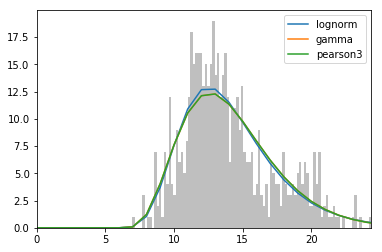


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.3411670333611477, 4.067737189292493, 9.490709944326486)

Distribution: gamma
Parameters: (5.252232022713325, 6.175162625863668, 1.5140473798580563)

Distribution: pearson3
Parameters: (0.8726704680754525, 14.127306804909308, 3.4698385545042782)


In [6]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )

## qq and pp plots

qq and pp plots are two ways of showing how well a distribution fits data, other than plotting the distribution on top of a historgram of values (as used above). 

Our intention here is not to describe the basis of the plots, but to show how to plot them in Python. In very basic terms they both describe how observed data is distributed compared with a theoretical distribution. If the fit is perfect then the data will aappear as a perfect diagonal line where the x and y values are the same (for standardised data, as we use here).

For more info on the plots see:

https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot
https://en.wikipedia.org/wiki/P%E2%80%93P_plot

So he is the code for the plots.

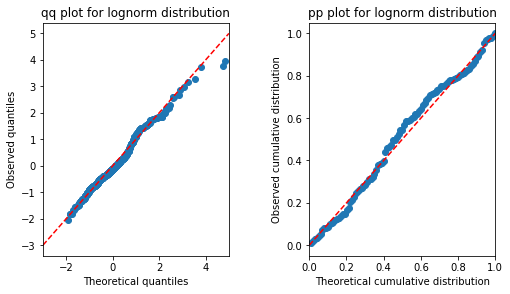

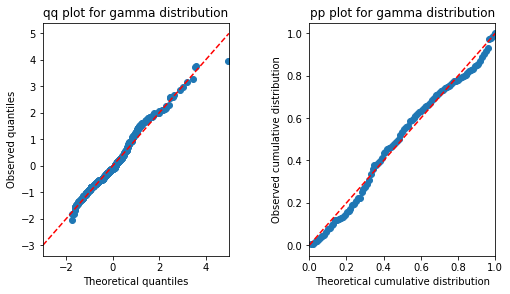

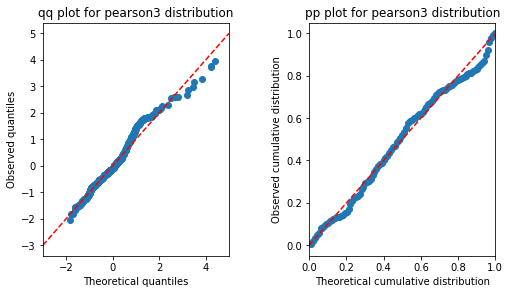

In [8]:
## qq and pp plots
    
data = y_std.copy()
data.sort()

# Loop through selected distributions (as previously selected)

for distribution in dist_names:
    # Set up distribution
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Get random numbers from distribution
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    
    # Create figure
    fig = plt.figure(figsize=(8,5)) 
    
    # qq plot
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    
    # pp plot
    ax2 = fig.add_subplot(122)
    
    # Calculate cumulative distributions
    bins = np.percentile(norm,range(0,101))
    data_counts, bins = np.histogram(data,bins)
    norm_counts, bins = np.histogram(norm,bins)
    cum_data = np.cumsum(data_counts)
    cum_norm = np.cumsum(norm_counts)
    cum_data = cum_data / max(cum_data)
    cum_norm = cum_norm / max(cum_norm)
    
    # plot
    ax2.plot(cum_norm,cum_data,"o")
    min_value = np.floor(min(min(cum_norm),min(cum_data)))
    max_value = np.ceil(max(max(cum_norm),max(cum_data)))
    ax2.plot([min_value,max_value],[min_value,max_value],'r--')
    ax2.set_xlim(min_value,max_value)
    ax2.set_xlabel('Theoretical cumulative distribution')
    ax2.set_ylabel('Observed cumulative distribution')
    title = 'pp plot for ' + distribution +' distribution'
    ax2.set_title(title)
    
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()